# Анализ проведенного A/B - теста

Задача: провести оценку результатов A/B-теста. В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оценить корректность проведения теста
- Проанализировать результаты теста

Чтобы оценить корректность проведения теста, проверим:

- Пересечение тестовой аудитории с конкурирующим тестом.
- Совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

---
Краткие выводы:

Проведенный эксперимент показал снижение конверсии на стадии просмотра страницы товара. Дальнейшие конверсии не различаются. Тест считаем неудачным, требовалось получить улучшение каждой метрики не менее, чем на 10%. Но мы получили снижение на первом шаге почти в 10% и никакой разницы в дальнейших шагах.

---

Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Обновление и импорт библиотек 

In [1]:
!pip install matplotlib -U

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: matplotlib in /home/jovyan/.local/lib/python3.7/site-packages (3.4.3)


In [2]:
!pip install seaborn -U

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.2)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

## Загрузка данных и первый взгляд

In [4]:
market_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
users = pd.read_csv('/datasets/final_ab_new_users.csv')
events = pd.read_csv('/datasets/final_ab_events.csv')
participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [5]:
market_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [6]:
display(users.head())
print('---------------------------------------')
print(users.info())
print('---------------------------------------')
print(users.describe().T)
print('---------------------------------------')
print('Дубликатов:', users.duplicated().mean())

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB
None
---------------------------------------
            count unique               top   freq
user_id     61733  61733  6D92872EF9CFF169      1
first_date  61733     17        2020-12-21   6290
region      61733      4                EU  46270
device      61733      4           Android  27520
---------------------------------------
Дубликатов: 0.0


In [7]:
display(events.head())
print('---------------------------------------')
print(events.info())
print('---------------------------------------')
print(events.describe())
print('---------------------------------------')
print('Дубликатов:', events.duplicated().mean())

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None
---------------------------------------
            details
count  62740.000000
mean      23.877631
std       72.180465
min        4.990000
25%        4.990000
50%        4.990000
75%        9.990000
max      499.990000
---------------------------------------
Дубликатов: 0.0


In [8]:
display(participants.head())
print('---------------------------------------')
print(participants.info())
print('---------------------------------------')
print(participants.describe().T)
print('---------------------------------------')
print('Дубликатов:', participants.duplicated().mean())

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB
None
---------------------------------------
         count unique                top   freq
user_id  18268  16666   79DF9D6EDC7A58CE      2
group    18268      2                  A   9655
ab_test  18268      2  interface_eu_test  11567
---------------------------------------
Дубликатов: 0.0


Данные хорошие. Пропуски имеются только в таблице `events` в столбце `details`, в нем указывается сумма платежа. Если `event_name` не `purchase`, в столбце будет пустое значение. Дальше необходимо привести даты к правильному типу, разобраться с попаданием одних пользователей в разные группы теста. 

## Предобработка данных

In [9]:
market_events['start_dt'] = pd.to_datetime(market_events['start_dt'], format='%Y-%m-%d')
market_events['finish_dt'] = pd.to_datetime(market_events['finish_dt'], format='%Y-%m-%d')
users['first_date'] = pd.to_datetime(users['first_date'], format='%Y-%m-%d')
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')

Привели формат и тип дат к необходимым для работы pandas.

In [10]:
participants[participants['user_id'].duplicated()]

,user_id,group,ab_test
6702,773ECB64E45DEBAB,A,interface_eu_test
6704,AABA4219186465C9,A,interface_eu_test
6705,2BA8FA8754D1FE50,B,interface_eu_test
6706,FB6F6BC119E1DBD5,B,interface_eu_test
6715,0ABA6D32AE7AFB9B,A,interface_eu_test
...,...,...,...
18227,EF2E4FAF26951358,A,interface_eu_test
18245,2B0CD24EE4291CA0,B,interface_eu_test
18252,CA6F4DAED160E5B1,A,interface_eu_test
18257,C70DF942E542DA69,A,interface_eu_test


1602 пользователя задублились в разные тесты.

In [11]:
participants = participants[participants['ab_test']=='recommender_system_test']
users = users[users['first_date'].between('2020-12-07', '2020-12-21')]

Для корректного анализа a/b теста выберем пользователей, попавших только в тест recommender_system_test и не попавших в другие тесты. А так же пользователей, зарегистрированных в даты набора пользователей для теста.

In [12]:
participiants = participants.merge(users[['user_id', 'region']], on='user_id')

In [13]:
participiants.head()

,user_id,group,ab_test,region
0,D1ABA3E2887B6A73,A,recommender_system_test,EU
1,A7A3664BD6242119,A,recommender_system_test,EU
2,DABC14FDDFADD29E,A,recommender_system_test,EU
3,04988C5DF189632E,A,recommender_system_test,EU
4,482F14783456D21B,B,recommender_system_test,EU


In [14]:
participiants[participiants['region']=='EU']['user_id'].count() / users[users['region']=='EU']['user_id'].count()

0.15

В тест попало 15% пользователей из региона EU, это соответствует техническому заданию. 

In [15]:
participiants.groupby('region').agg(cnt=('user_id', 'count')).sort_values(by='cnt', ascending=False).reset_index()

,region,cnt
0,EU,6351
1,N.America,223
2,APAC,72
3,CIS,55


In [16]:
participiants = participiants[participiants['region']=='EU']

In [17]:
participants_a = participants[participants['group']=='A']
participants_b = participants[participants['group']=='B']

Оставим только тех пользователей, на которых был нацелен тест - аудиторию региона EU.

In [18]:
events = (events[events['user_id'].isin(participants['user_id'])]
          .merge(participants, on='user_id')
          .drop(columns='ab_test')
         )

Выберем действия только тех пользователей, что попали в тест.

## EDA 

### Конверсия в воронке
Как меняется конверсия в воронке на разных этапах?

In [19]:
event_count = (events.groupby('event_name')
                .agg(events_cnt=('user_id','count'), 
                     users_cnt=('user_id','nunique'))
                .sort_values(by='users_cnt', ascending=False)
                .reset_index()
                .reindex([0,1,3,2])
                .reset_index(drop=True)
               )
event_count['perc_all_users'] = (event_count['users_cnt'] / participants['user_id'].nunique()).map('{:.2%}'.format)
event_count['perc_from_last_event'] = (1 + event_count['users_cnt'].pct_change().fillna(0)).map('{:.2%}'.format)

In [20]:
event_count

,event_name,events_cnt,users_cnt,perc_all_users,perc_from_last_event
0,login,11190,3675,54.84%,100.00%
1,product_page,6930,2303,34.37%,62.67%
2,product_cart,3247,1079,16.10%,46.85%
3,purchase,3331,1128,16.83%,104.54%


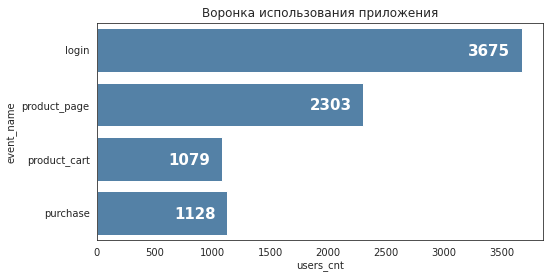

In [21]:
sns.set_style("white")

fig = plt.figure(figsize =(8, 4))
ax = sns.barplot(data=event_count, y='event_name', x='users_cnt', color='steelblue')

# Подпишем бары значениями
for i in ax.patches:
    # Добавим количество
    ax.text(i.get_width()-100, i.get_y()+0.5, int(i.get_width()), fontsize=15, color='white', fontweight='bold', ha='right')
plt.title('Воронка использования приложения')
plt.show()

Почти 55% пользователей отвалилось сразу после регистрации. Но из оставшихся и совершивших Вход на сайт, 34% просмотрели страницу товара, а 16.1% совершили покупку. 46.8% пользователей, просмотревших страницу товара, совершают покупку. 
Некоторые пользователи пропускают шаг просмотра корзины и сразу покупают. 

Пропуск этапа корзины возможен, если при просмотре товара, можно сразу его купить и оплатить. Без захода в корзину. 

### События на пользователя
Количество событий на пользователя одинаково распределены в выборках?

In [22]:
user_events = (events.groupby(['user_id', 'group'])
               .agg(event_cnt=('user_id', 'count'))
               .reset_index()
               .sort_values(by='group'))
user_events

,user_id,group,event_cnt
1837,825B68CAAB0C8D43,A,8
3189,DE078758B0515023,A,8
3188,DDF33D76FBEBA3EF,A,4
1922,891458DEF142C0A3,A,16
1923,891846A96F23C9FB,A,4
...,...,...,...
1936,89EF9F0C1676188A,B,10
1931,89545C7F903DBA34,B,21
1930,894A2506B3A50D03,B,6
1965,8C0C9BBA51E96C48,B,3


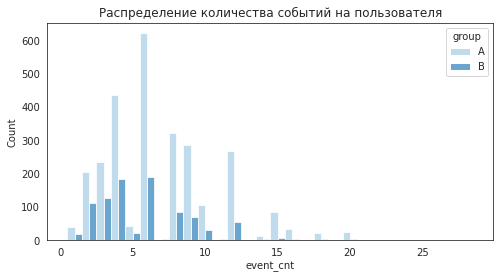

In [23]:
sns.set_style("white")

fig = plt.figure(figsize =(8, 4))
ax = sns.histplot(data=user_events, x='event_cnt', hue='group', palette="Blues", discrete=True, multiple='dodge')

plt.title('Распределение количества событий на пользователя')
plt.show()

Выборки теста распределены неравномерно

### Выборки тестов
В выборках встречаются одни и те же пользователи?

In [24]:
pd.pivot_table(participiants, 
               values='region', 
               index=['user_id'],
               columns=['group'], 
               aggfunc='count').dropna()

group,A,B
user_id,,


В выборках не встречаются одни и те же пользователи.

### Распределение событий по дням
Как число событий распределено по дням?

In [25]:
events_day_cnt = events.groupby([events['event_dt'].dt.date, 'group']).agg(cnt=('event_name', 'count')).reset_index()

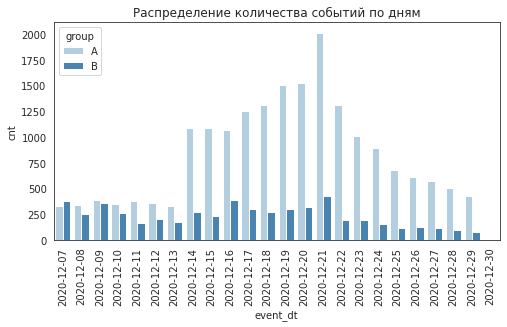

In [26]:
sns.set_style("white")

fig = plt.figure(figsize =(8, 4))
ax = sns.barplot(data=events_day_cnt, x='event_dt', y='cnt', hue='group', palette='Blues')
ax.tick_params(axis='x', rotation=90)
plt.title('Распределение количества событий по дням')
plt.show()

### Особенности данных
Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

In [27]:
participants_a['user_id'].nunique()

3824

In [28]:
participants_b['user_id'].nunique()

2877

In [29]:
market_events[(market_events['start_dt'].isin(events['event_dt'].dt.date))
              |(market_events['finish_dt'].isin(events['event_dt'].dt.date))]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Последние 5 дней теста пересекаются с маркетинговой кампанией.   Необходимо быть с ними крайне осторожными.

В группах разное количество пользователей. Так же очень много пользователей, зарегистрированных на тест, не совершали действий.

## Оценка результатов A/B-тестирования

### Проверка статистической разницы долей z-критерием.

In [30]:
events_group_a = (events[events['group']=='A']
                  .groupby(['event_name'])
                  .agg(users_cnt=('user_id', 'nunique'))
                  .sort_values(by='users_cnt', ascending=False)
                  .reset_index()
                  .reindex([0,1,3,2])
                  .reset_index(drop=True)
                 )
events_group_b = (events[events['group']=='B']
                  .groupby(['event_name'])
                  .agg(users_cnt=('user_id', 'nunique'))
                  .sort_values(by='users_cnt', ascending=False)
                  .reset_index()
                  .reindex([0,1,3,2])
                  .reset_index(drop=True)
                 )

#### Гипотеза H<sub>0</sub> - доли пользователей, после проведения А/B теста, на каждом шаге воронки равны.
Гипотеза H<sub>1</sub> - доли пользователей, после проведения А/B теста, на каждом шаге воронки различаются.

In [31]:
pvalues = []
for i in range(1, len(event_count)):
    stat, pval = proportions_ztest([events_group_a['users_cnt'][i], events_group_b['users_cnt'][i]], 
                                   [events_group_a['users_cnt'][0], events_group_b['users_cnt'][0]])
    pvalues.append(pval)

In [32]:
reject, p_value_corrected, sidak_corr, bonf_corr = multipletests(pvalues, alpha=0.05, method='holm-sidak')

In [33]:
# Зададим переменные для выделения текста цветом
cred = '\033[91m'
cgreen = '\033[92m'
cend = '\033[0m'

print('Скорректированное альфа значение:', bonf_corr)
print('-----------------------------------------------------------------------------')
for i in range(0, len(p_value_corrected)):
    print('Гипотеза о равенстве долей в событии', event_count['event_name'][i+1])
    print('p-значение:', p_value_corrected[i])
    if p_value_corrected[i] < bonf_corr:
        print(cred + 'Отвергаем нулевую гипотезу: между долями есть значимая разница' + cend)
    else:
        print(cgreen + 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными' + cend)
    print('-----------------------------------------------------------------------------')

Скорректированное альфа значение: 0.016666666666666666
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии product_page
p-значение: 1.2932885910643677e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии product_cart
p-значение: 0.14534814557238196
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии purchase
p-значение: 0.03487531269516109
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------


### Результаты A/B-тестирования.

In [34]:
events_group_a['perc_of_all'] = (events_group_a['users_cnt'] / participants_a['user_id'].nunique()).map('{:.2%}'.format)
events_group_b['perc_of_all'] = (events_group_b['users_cnt'] / participants_b['user_id'].nunique()).map('{:.2%}'.format)
events_group_a['perc_from_last_event'] = (1 + events_group_a['users_cnt'].pct_change().fillna(0)).map('{:.2%}'.format)
events_group_b['perc_from_last_event'] = (1 + events_group_b['users_cnt'].pct_change().fillna(0)).map('{:.2%}'.format)

In [35]:
print('Воронка группы A:')
display(events_group_a)
print('Воронка группы B:')
display(events_group_b)

Воронка группы A:


,event_name,users_cnt,perc_of_all,perc_from_last_event
0,login,2747,71.84%,100.00%
1,product_page,1780,46.55%,64.80%
2,product_cart,824,21.55%,46.29%
3,purchase,872,22.80%,105.83%


Воронка группы B:


,event_name,users_cnt,perc_of_all,perc_from_last_event
0,login,928,32.26%,100.00%
1,product_page,523,18.18%,56.36%
2,product_cart,255,8.86%,48.76%
3,purchase,256,8.90%,100.39%


Проведенный эксперимент показал снижение конверсии на стадии просмотра страницы товара. Дальнейшие конверсии не различаются. Тест считаем неудачным, требовалось получить улучшение каждой метрики не менее, чем на 10%. Но мы получили снижение на первом шаге почти в 10% и никакой разницы в дальнейших шагах.

## Выводы

Данные хорошие. Пропуски имеются только в таблице `events` в столбце `details`, в нем указывается сумма платежа. Если `event_name` не `purchase`, в столбце будет пустое значение. Дальше необходимо привести даты к правильному типу, разобраться с попаданием одних пользователей в разные группы теста. 

1602 пользователя задублились в разные группы или тесты. Для корректного анализа a/b теста выберем пользователей, попавших только в тест recommender_system_test. 
Всего 14% пользователей из региона EU попало в тест. 95% всей выборки приходится на EU регион. 

Последние 5 дней теста пересекаются с маркетинговыми кампанями.

Почти 55% пользователей отвалилось сразу после регистрации. Но из оставшихся и совершивших Вход на сайт, 34% просмотрели страницу товара, а 16.1% совершили покупку. 46.8% пользователей, просмотревших страницу товара, совершают покупку. Некоторые пользователи пропускают шаг просмотра корзины и сразу покупают.

Выборки теста распределены неравномерно.

В группах разное количество пользователей. Так же очень много пользователей, зарегистрированных на тест, не совершали действий.

<b>Проведенный эксперимент показал снижение конверсии на стадии просмотра страницы товара. Дальнейшие конверсии не различаются. Тест считаем неудачным, требовалось получить улучшение каждой метрики не менее, чем на 10%. Но мы получили снижение на первом шаге почти в 10% и никакой разницы в дальнейших шагах.</b>